# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
%matplotlib inline

import numpy as np
import pandas as pd

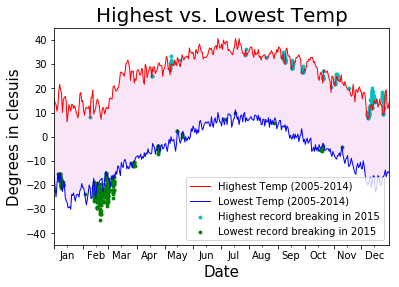

In [6]:
#Load dataset using pandas.read_csv
dataset = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')

#convert all data to actual degrees clesuis not tenth
dataset['Data_Value'] = dataset['Data_Value']*0.1

#Convert dates into pandas datetime
#Extract year as a new column
#convert date into month_day
#Exclude February 29th from data
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['Year'] = dataset['Date'].dt.year
dataset['month_day'] = dataset['Date'].dt.strftime('%m-%d')
dataset = dataset[dataset['month_day']!='02-29']

#grouping data of 2014 and 2015 only
#Sorting data by day of month and selecting the highest/lowest value of temperature
max_temp = dataset[(dataset['Year'] >= 2005) & (dataset.Year <2014) & (dataset.Element == 'TMAX')].groupby(['month_day'])['Data_Value'].max()
min_temp = dataset[(dataset.Year >=2005) & (dataset.Year <2014) & (dataset.Element == 'TMIN')].groupby('month_day')['Data_Value'].min()

#Changing column name from datavalue to max/min temperature
#we used reset index so i can merge both dataframes
dataset = dataset.merge(max_temp.reset_index(drop=False).rename(columns={'Data_Value':'Max_temp'}),on='month_day', how='left')
dataset = dataset.merge(min_temp.reset_index(drop=False).rename(columns={"Data_Value":"Min_temp"}),on='month_day', how='left')

#dataset = dataset[dataset.month_day == '01-01']
#if you wrote this line of code, you'd find all values of 01-01 over years are the same

#finding breaks higer or lower values in 2015
record_high = dataset[(dataset.Year == 2015) & (dataset.Data_Value > dataset.Max_temp)]
record_low  = dataset[(dataset.Year == 2015) & (dataset.Data_Value < dataset.Min_temp)]

#finding the highest or lowest value in thatt outstanding day
record_high_one = record_high.groupby('month_day')['Max_temp'].max()
record_low_one = record_high.groupby('month_day')['Min_temp'].min()
#record_high_onee = record_high.reset_index(drop=False).rename(columns={'Data_value':"Top Max_Temp"})
#record_low_one = record_low.reset_index(drop=False).rename(columns={'Data_value':"Bottom Min_Temp"})
dataset = dataset.merge(record_high_one.reset_index(drop=False), on='month_day', how='left')
dataset = dataset.merge(record_low_one.reset_index(drop=False), on='month_day', how='left')
dataset = dataset.rename(columns={'Max_temp_x':'Max_temp','Max_temp_y':'topMax_temp','Min_temp_x':'Min_temp','Min_temp_y':'bottomMin_temp'})

#Now we start plotting
#set X-axis for year 2020 or any year since we only need days
#Note that x axis should have 365 days as per points, so i could not use year2020 since it had 366 days
dataaxis = np.arange('2015-01-01','2016-01-01', dtype='datetime64[D]')
plt.figure()
plt.plot(dataaxis,max_temp,color='red', linewidth=1)
plt.plot(dataaxis,min_temp,color='blue', linewidth=1)

#Now we need to plot 2015 data points
#Note that i cant use dataaxis since the both would have different number of values
#x axis is 365 while y axis is much lower
plt.scatter(record_high.Date.values, record_high.Data_Value.values, color='c', s=8)
plt.scatter(record_low.Date.values, record_low.Data_Value.values, color='g', s=8)

#Adding legends and labels
ax=plt.gca()
ax.axis(['2015-01-01','2015-12-31',-45,45])
plt.xlabel("Date", fontsize=15)
plt.ylabel('Degrees in clesuis', fontsize=15)
plt.title('Highest vs. Lowest Temp', fontsize=20)
plt.legend(['Highest Temp (2005-2014)','Lowest Temp (2005-2014)','Highest record breaking in 2015','Lowest record breaking in 2015'],loc=4,frameon=True)

#shading
ax.fill_between(dataaxis, max_temp, min_temp, facecolor='m', alpha=0.1)

#Formatting axes
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=15)) # Put the label at the minor tick so it's in the center.
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

ax